### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os

### Opening one image 

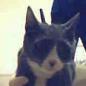

In [3]:
with Image.open('CATS_DOGS/CATS_DOGS/test/CAT/10107.jpg') as im:
    display(im)

### Create a list of image filenames

In [4]:
path = 'CATS_DOGS//CATS_DOGS'
image_names = []
for folder , subfolder, filnames in os.walk(path):
    for images in filnames:
        image_names.append(folder+'\\'+images)

print('Images: ',len(image_names))

Images:  24994


### Create a dataframe of image sizes (W x H)

In [5]:
image_sizes = []
img_rejected = []

for img in image_names:
    try:
        with Image.open(img) as im:
            image_sizes.append(im.size)
    except Exception as e:
        img_rejected.append(img)

In [6]:
print(len(image_sizes))
print(len(img_rejected))

24994
0


In [7]:
df = pd.DataFrame(image_sizes)

In [8]:
df.describe()

,0,1
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


### Maximum values for each column in mean range
#### shortest width was 42 and shortest heigth was 33

### Lets look at the each pixel

In [9]:
dog = Image.open('CATS_DOGS/CATS_DOGS/train/DOG/14.jpg')

(500, 387)


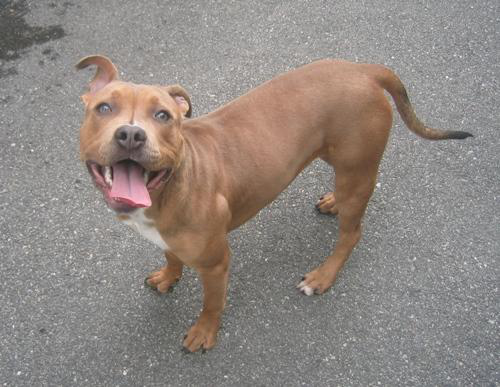

In [10]:
print(dog.size)
display(dog)
r,b,g = dog.getpixel((0,0))

In [11]:
r,b,g

(90, 95, 98)

In [12]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

90 95 98


In [13]:
transform = transforms.Compose([transforms.ToTensor()])
im = transform(dog)
print(im.shape)

torch.Size([3, 387, 500])


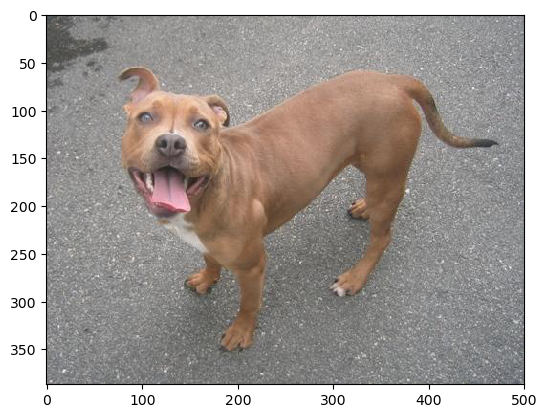

In [14]:
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [15]:
np.transpose(im.numpy(), (1,2,0)).shape

(387, 500, 3)

In [16]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

In [17]:
small_dog = Image.open('CATS_DOGS/CATS_DOGS/train/DOG/11.jpg')

In [18]:
small_dog.size

(135, 102)

In [19]:
transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])

torch.Size([3, 224, 296])


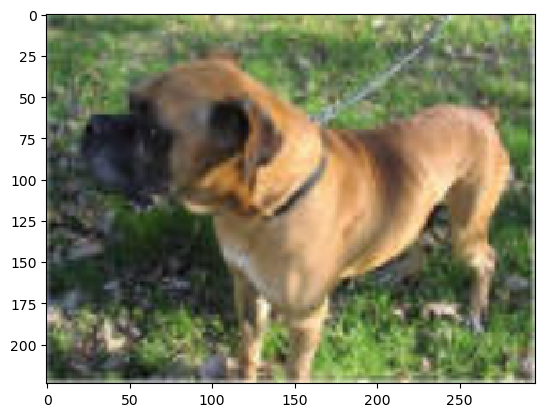

In [20]:
im = transform(small_dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

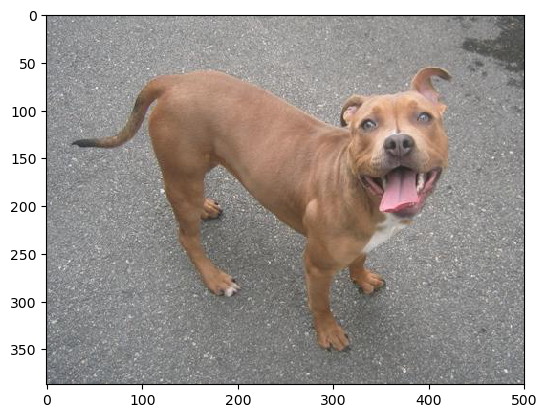

In [21]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(1),transforms.ToTensor()])
img = transform(dog)
plt.imshow(np.transpose(img.numpy(),(1,2,0)))

### Lets combine all the operations together

In [22]:
transform = transforms.Compose([transforms])

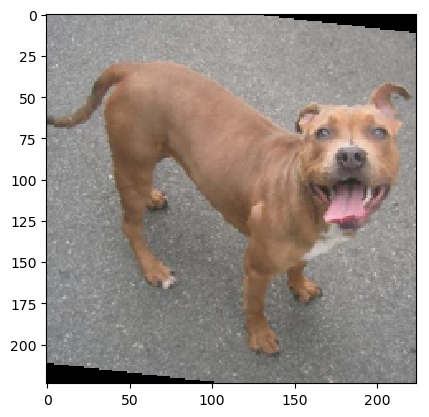

In [23]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    transforms.Resize(224),
    transforms.RandomRotation(30),
    transforms.CenterCrop(224),
    transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))


In [24]:
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

### Preparing trainning and testing datasets loading

In [25]:
root = 'CATS_DOGS/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

In [26]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size =10, shuffle = False)

In [27]:
len(train_data),len(test_data)

(18743, 6251)

In [28]:
class_names = train_data.classes

In [29]:
for images, labels in train_loader:
    break

label:  [1 1 0 0 1 1 0 1 0 0]
class:  DOG DOG CAT CAT DOG DOG CAT DOG CAT CAT


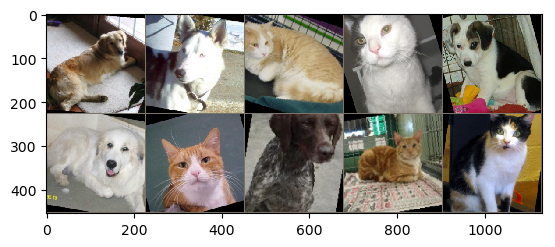

In [98]:
print('label: ', labels.numpy())
print('class: ', *np.array([class_names[i] for i in labels]))

from torchvision.utils import make_grid
im = make_grid(images, nrow=5)

inv_normilize = transforms.Normalize(
 mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
 std = [1/0.229, 1/0.224, 1/0.225])

im = inv_normilize(im)

plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [31]:
import torch.nn.functional as F
import torch.nn as nn
import torch

In [32]:
class C_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [41]:
torch.manual_seed(101)
CNNmodel = C_NN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

C_NN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b , (X_train, y_train) in enumerate(train_loader):
        
        if b == max_trn_batch:
            break
        b+=1
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()

        
        trn_corr += batch_corr
        
        optimizer.zero_grad
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_val, 1)[1]
            tst_crr += (predicted == y_test)
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

### Building the models by using the pretrained models 

In [33]:
from torchvision import models

In [34]:
AlexNetmodel = models.alexnet(pretrained=True)

In [36]:
AlexNetmodel.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [37]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [79]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [80]:
AlexNetmodel.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (

In [81]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [82]:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


In [83]:
# Getting only trained parameters
total_params = sum(p.numel() for p in AlexNetmodel.parameters() if p.requires_grad)

In [84]:
# Getting all parameters
total__params = sum(p.numel() for p in AlexNetmodel.parameters())

In [85]:
total__params-total_params

2469696

In [86]:
total__params

11909954

In [87]:
total_params

9440258

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.parameters(), lr=0.01)

In [89]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 2.45613432  accuracy:  86.900%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00490682  accuracy:  88.700%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.64764321  accuracy:  89.733%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.02591378  accuracy:  90.100%

Duration: 399 seconds


In [96]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(1791)]
Test accuracy: 59.700%


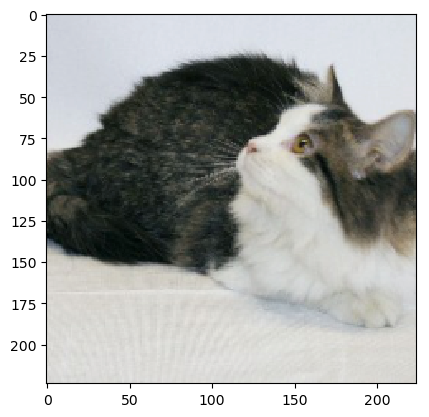

In [99]:
x = 2019
im = inv_normilize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [100]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG
